# WMT of tendency terms
## Table Of Contents: <a class="anchor" id="top"> </a>
* [Make histogram of each term](#first-bullet)
* [Save histograms](#second-bullet)

# 1) Make histogram of each term <a class='anchor' id='first-bullet'> </a>

In [1]:
import xarray as xr
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
import fastjmd95
import pop_tools
import gcsfs
from xhistogram.xarray import histogram

In [2]:
from intake import open_catalog
url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/CESM_POP.yaml"
cat = open_catalog(url)
ds  = cat["CESM_POP_hires_control"].to_dask()

In [3]:
#Load in tendencies

import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [4]:
tracers = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/tracer_tendencies_40yr.zarr'))
drhodts = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/drhodts_tendencies_40yr.zarr'))
rho_cab = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/rho_bih_cab_tendencies_40yr.zarr'))

tendencies = xr.merge([tracers, drhodts, rho_cab])

In [5]:
tendencies

<xarray.Dataset>
Dimensions:    (time: 14965, nlat: 2400, nlon: 3600)
Coordinates:
  * nlat       (nlat) int64 0 1 2 3 4 5 6 ... 2393 2394 2395 2396 2397 2398 2399
  * nlon       (nlon) int64 0 1 2 3 4 5 6 ... 3593 3594 3595 3596 3597 3598 3599
  * time       (time) object 0046-01-02 00:00:00 ... 0087-01-01 00:00:00
Data variables:
    SSS_bih    (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SST_bih    (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    drhods     (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    drhodt     (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    cabbeling  (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    rho_bih    (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>

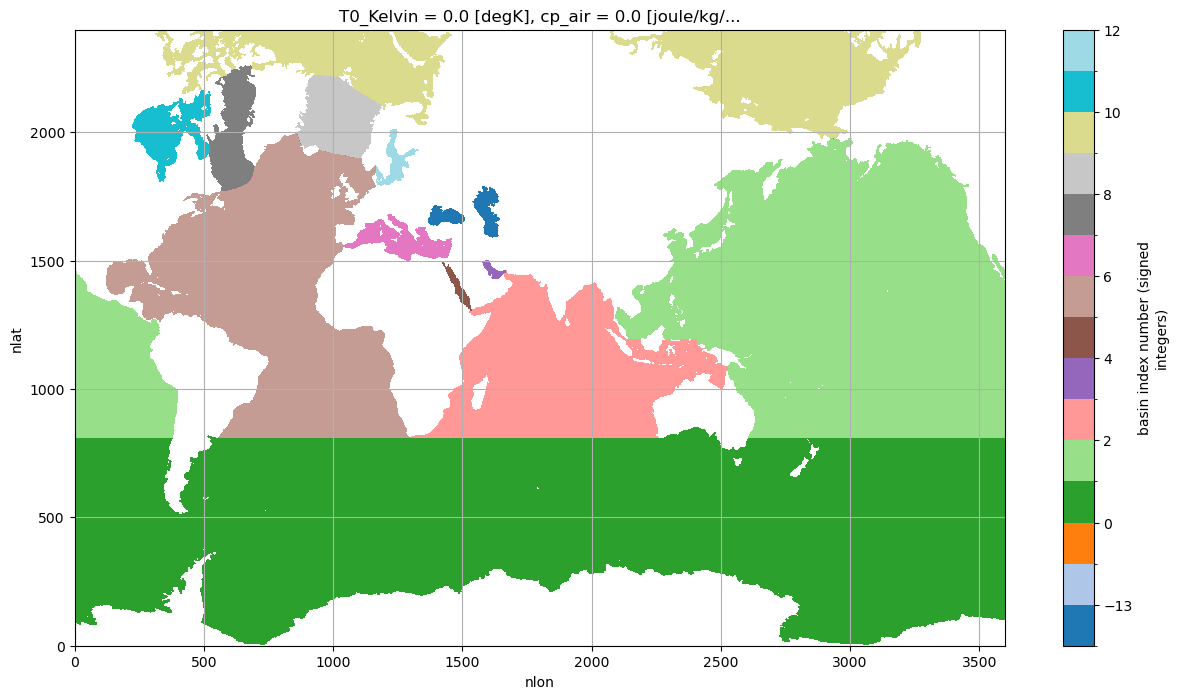

In [20]:
#to know which region index value is what basin
plt.figure(figsize=(15,8))
regions = np.unique(ds.REGION_MASK)
ds.REGION_MASK.where(ds.KMT>0).plot.contourf(levels=regions, cmap='tab20')
plt.grid();

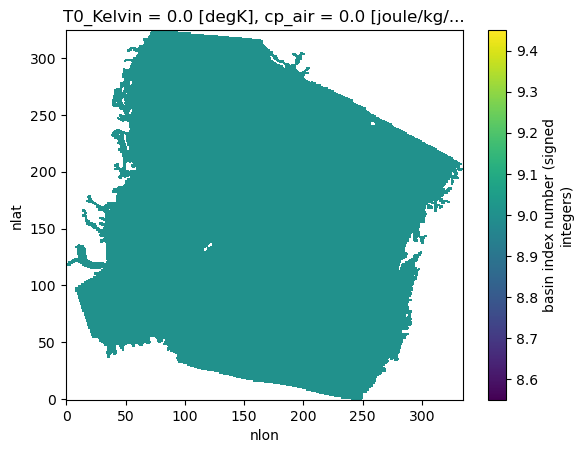

In [55]:
ds.REGION_MASK.where(ds.REGION_MASK==9, drop=True).plot()

In [21]:
regions

array([-14., -13.,  -1.,   0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,
         8.,   9.,  10.,  11.,  12.])

In [6]:
#assign each region index value to basin name

caspian_sea = -14
black_sea = -13
#unknown = -1
#unknown = 0
southern_ocean = 1
pacific_ocean = 2
indian_ocean = 3
persian_gulf = 4
red_sea = 5
atlantic_ocean = 6
med_sea = 7
lab_sea = 8
norwegian_sea = 9
arctic_ocean = 10
hudson_bay = 11
baltic_sea = 12

In [7]:
#combining atl, lab and norwegian sea masks together
nor_bool = ds.REGION_MASK.where(ds.REGION_MASK==9).notnull()
lab_bool = ds.REGION_MASK.where(ds.REGION_MASK==8).notnull()
atl_bool = ds.REGION_MASK.where(ds.REGION_MASK==6).notnull()

In [8]:
atl_mask = (nor_bool+lab_bool+atl_bool)

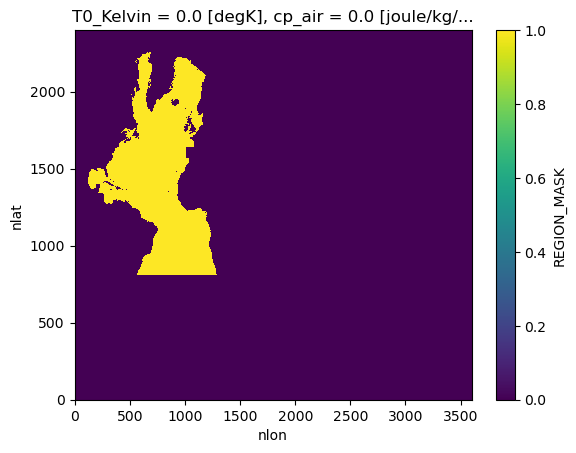

In [8]:
atl_mask.plot()

# Split the tendencies by basin

In [9]:
all_tendencies = list(tendencies)

In [10]:
def basin_selection(tend_term, basin):
    tendency_in_basin = tend_term.where(ds.REGION_MASK==basin)
    return tendency_in_basin

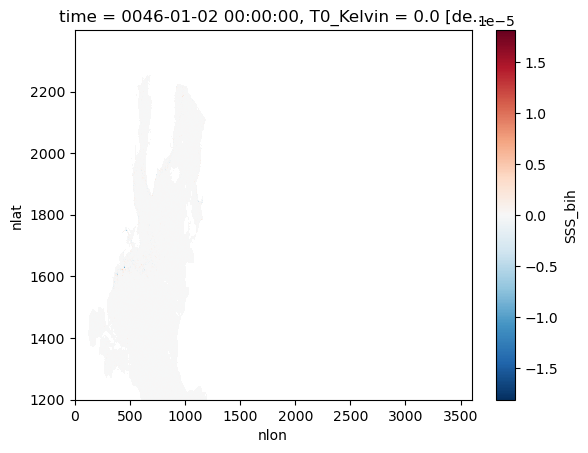

In [11]:
tendencies.SSS_bih.where(atl_mask).isel(nlat=slice(1200, None))[0].plot()

In [11]:
#Atlantic Ocean - going to add 'NATL' prefix after adding natl_ocean+nor_sea+lab_sea respective vars
natl_ocean = xr.merge([tendencies[var].where(atl_mask).isel(nlat=slice(1200, None)
                                                          ).rename('NATL_' + var) for var in all_tendencies])
satl_ocean = xr.merge([basin_selection(tendencies[var], 
                                      atlantic_ocean).isel(nlat=slice(None, 1200)
                                                          ).rename('SATL_' + var) for var in all_tendencies])

#Pacific Ocean
npac_ocean = xr.merge([basin_selection(tendencies[var], 
                                       pacific_ocean).isel(nlat=slice(1200, None)
                                                          ).rename('NPAC_' + var) for var in all_tendencies])
spac_ocean = xr.merge([basin_selection(tendencies[var], 
                                       pacific_ocean).isel(nlat=slice(None, 1200)
                                                          ).rename('SPAC_' + var) for var in all_tendencies])

#Indian Ocean
ind_ocean = xr.merge([basin_selection(tendencies[var], indian_ocean).rename('IND_' + var) for var in all_tendencies])

#Arctic Ocean
arc_ocean = xr.merge([basin_selection(tendencies[var], arctic_ocean).rename('ARC_' + var) for var in all_tendencies])

#Southern Ocean
south_ocean = xr.merge([basin_selection(tendencies[var], 
                                        southern_ocean).rename('South_' + var) for var in all_tendencies])

In [12]:
natl_ocean

<xarray.Dataset>
Dimensions:             (nlat: 1200, nlon: 3600, time: 14965)
Coordinates: (12/54)
  * nlat                (nlat) int64 1200 1201 1202 1203 ... 2396 2397 2398 2399
  * nlon                (nlon) int64 0 1 2 3 4 5 ... 3595 3596 3597 3598 3599
  * time                (time) object 0046-01-02 00:00:00 ... 0087-01-01 00:0...
    ANGLE               (nlat, nlon) float64 dask.array<chunksize=(1200, 3600), meta=np.ndarray>
    ANGLET              (nlat, nlon) float64 dask.array<chunksize=(1200, 3600), meta=np.ndarray>
    DXT                 (nlat, nlon) float64 dask.array<chunksize=(1200, 3600), meta=np.ndarray>
    ...                  ...
    salt_to_ppt         float64 0.0
    sea_ice_salinity    float64 0.0
    sflux_factor        float64 0.0
    sound               float64 0.0
    stefan_boltzmann    float64 0.0
    vonkar              float64 0.0
Data variables:
    NATL_SSS_bih        (time, nlat, nlon) float32 dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    NATL_SST_bih        (time, nlat, nlon) float32 dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    NATL_drhods         (time, nlat, nlon) float32 dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    NATL_drhodt         (time, nlat, nlon) float32 dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    NATL_cabbeling      (time, nlat, nlon) float32 dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    NATL_rho_bih        (time, nlat, nlon) float32 dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>

# Plot tendencies by basin

In [12]:
#New ds after dthetadt*drhodt and dSdt*drhods
def new_ds(ds, prefix):
    newds = xr.merge([(ds[prefix+'SST_bih']*ds[prefix+'drhodt']).rename(prefix+'sst'),
                      (ds[prefix+'SSS_bih']*ds[prefix+'drhods']).rename(prefix+'sss'),
                       ds[prefix+'rho_bih'].rename(prefix+'rho'),
                       ds[prefix+'cabbeling'].rename(prefix+'cabbeling')])
    return newds

In [13]:
natl_tend = new_ds(natl_ocean, 'NATL_')
satl_tend = new_ds(satl_ocean, 'SATL_')

npac_tend = new_ds(npac_ocean, 'NPAC_')
spac_tend = new_ds(spac_ocean, 'SPAC_')

ind_tend = new_ds(ind_ocean, 'IND_')

arc_tend = new_ds(arc_ocean, 'ARC_')

south_tend = new_ds(south_ocean, 'South_')

In [14]:
natl_tendencies = list(natl_tend)
satl_tendencies = list(satl_tend)
npac_tendencies = list(npac_tend)
spac_tendencies = list(spac_tend)
ind_tendencies = list(ind_tend)
arc_tendencies = list(arc_tend)
south_tendencies = list(south_tend)

## North Atlantic

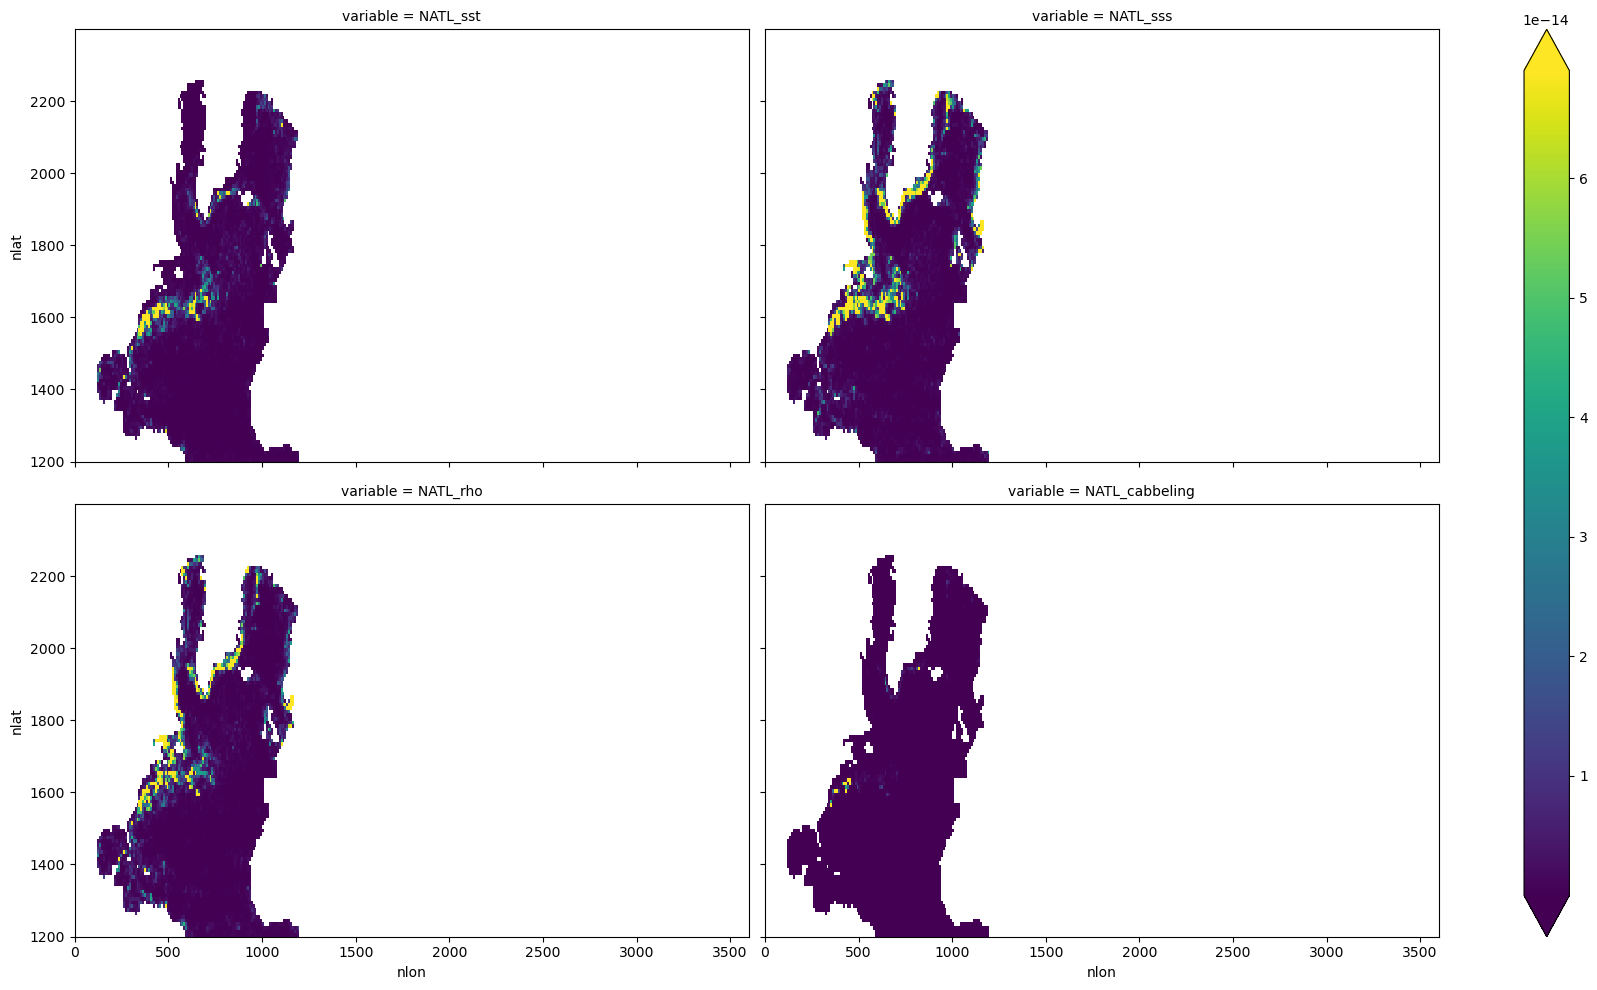

In [19]:
(natl_tend.isel(time=0)**2).coarsen(nlon=10, nlat=10).mean().to_array().plot(col='variable', 
                                                                         col_wrap=2, robust=True, 
                                                                         figsize=(18, 10))

## South Atlantic

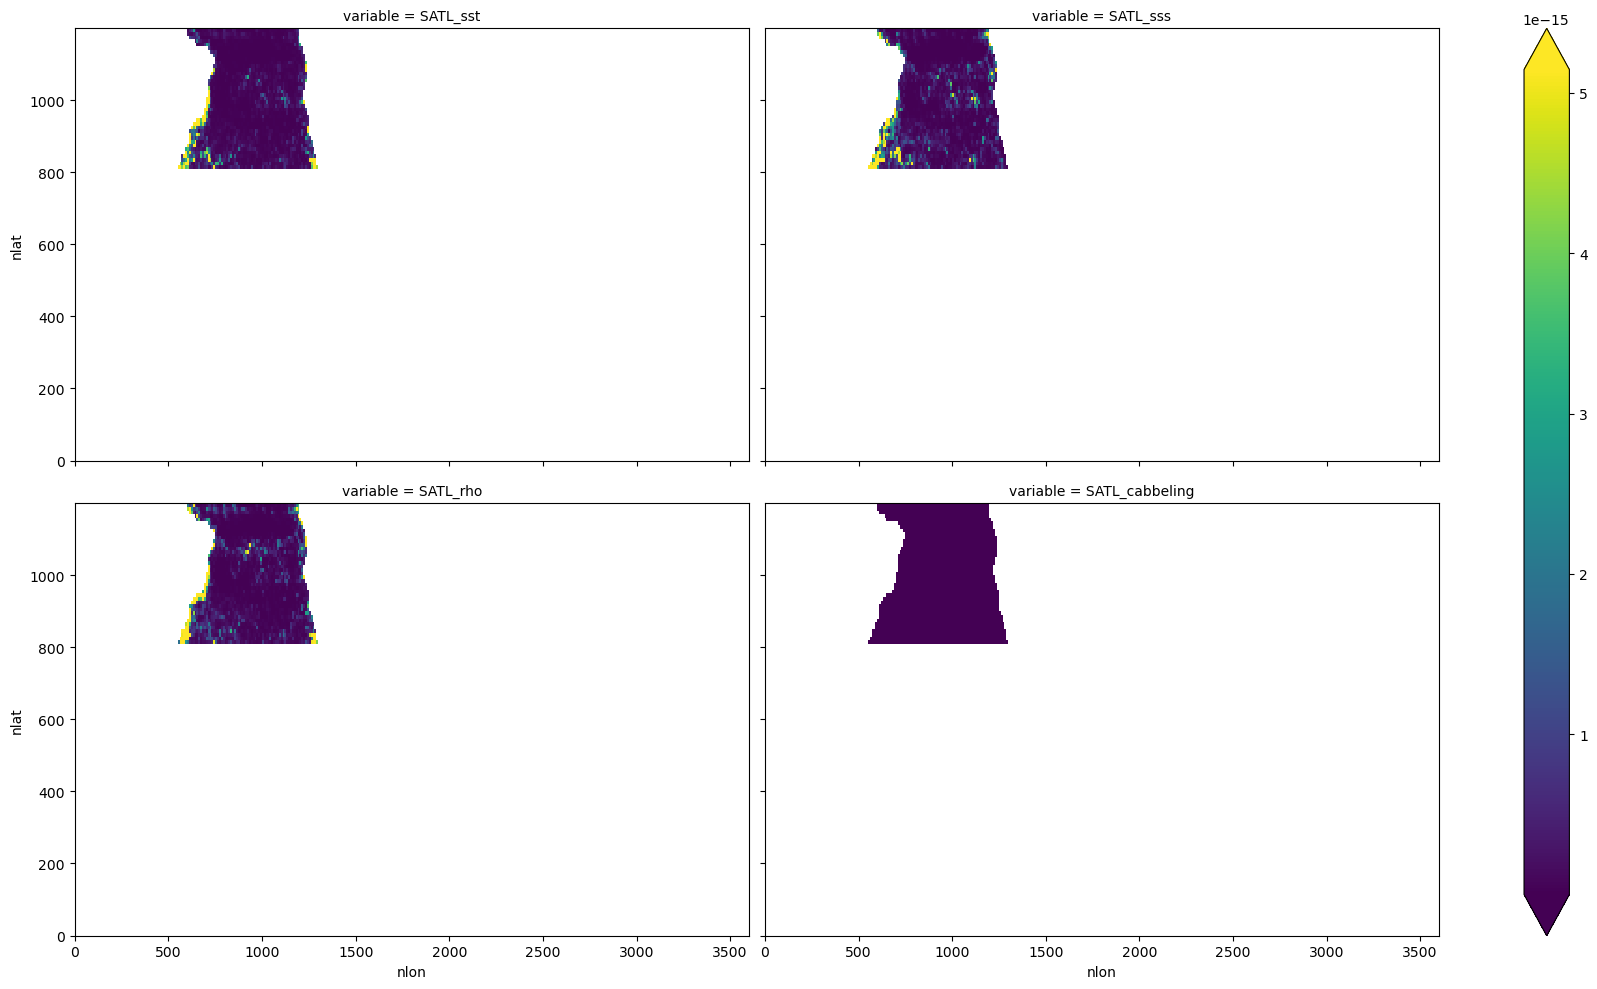

In [20]:
(satl_tend.isel(time=0)**2).coarsen(nlon=10, nlat=10).mean().to_array().plot(col='variable', 
                                                                         col_wrap=2, robust=True, 
                                                                         figsize=(18, 10))

## North Pacific

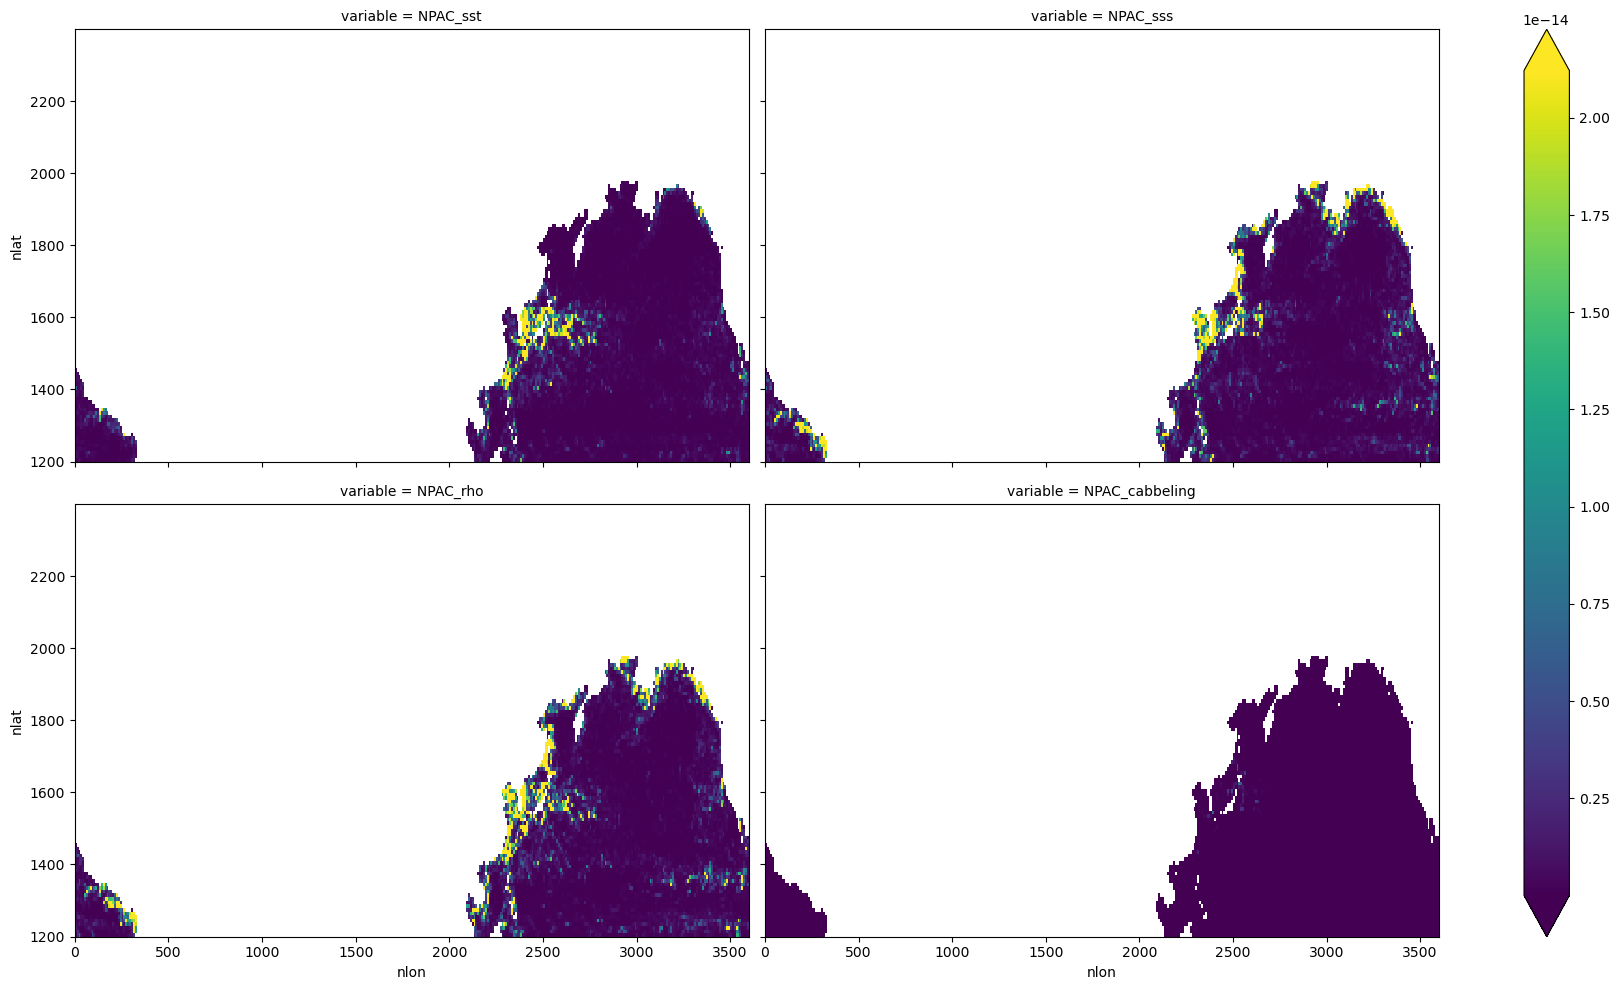

In [21]:
(npac_tend.isel(time=0)**2).coarsen(nlon=10, nlat=10).mean().to_array().plot(col='variable', 
                                                                         col_wrap=2, robust=True, 
                                                                         figsize=(18, 10))

## South Pacific

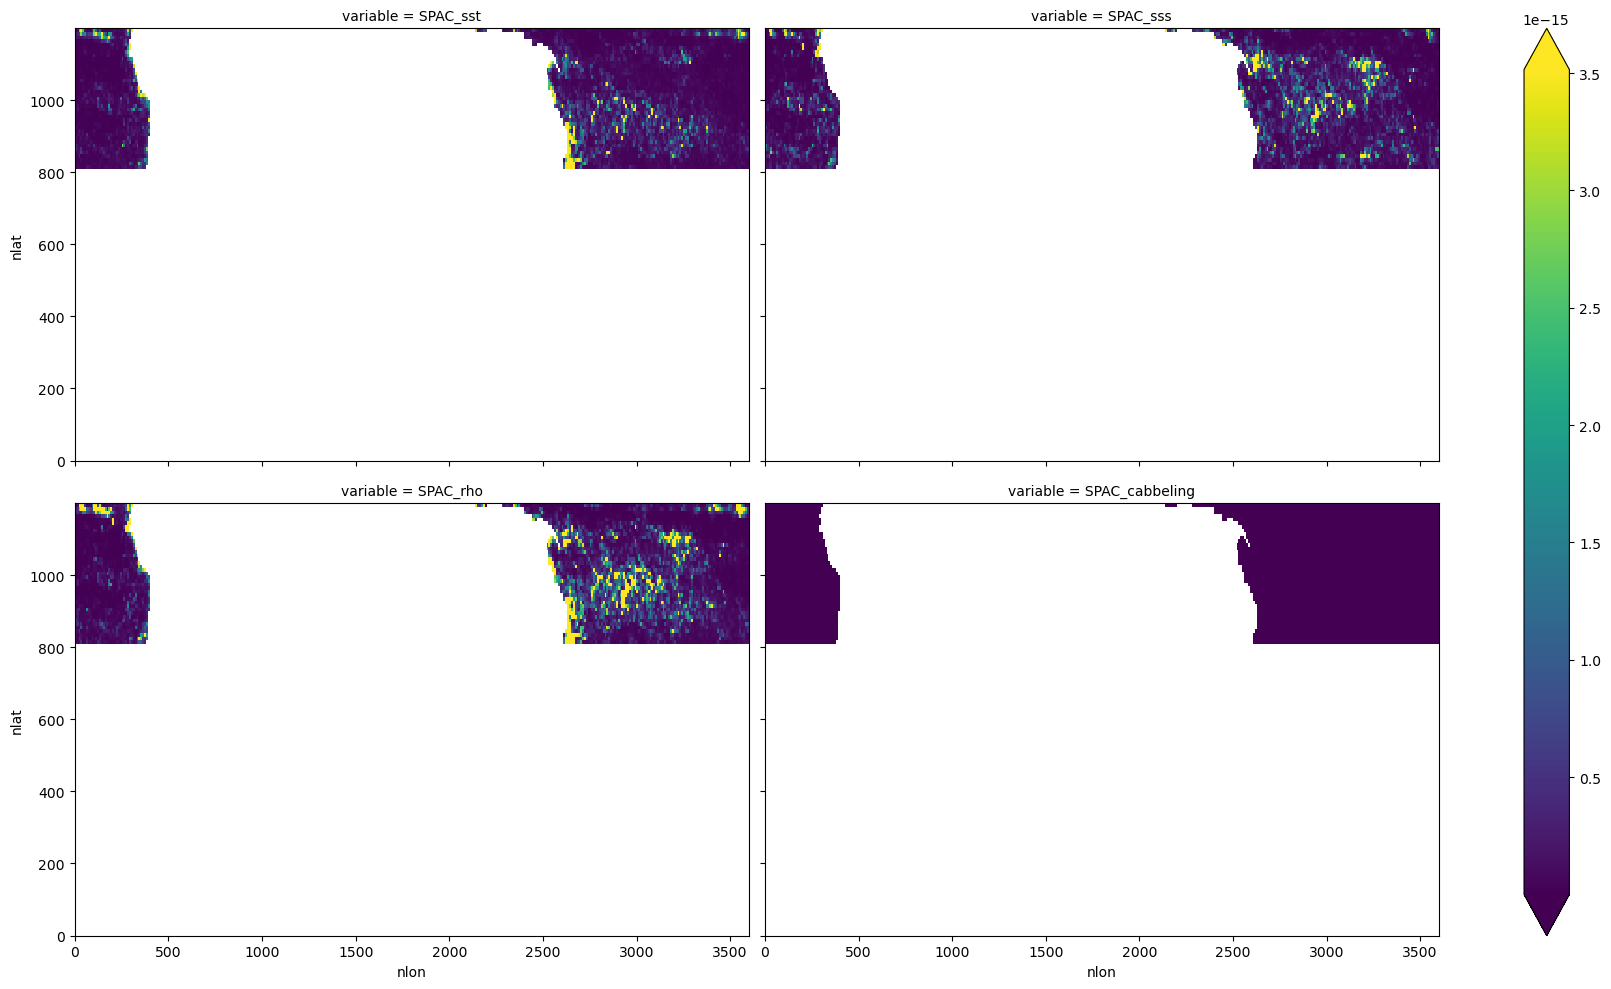

In [22]:
(spac_tend.isel(time=0)**2).coarsen(nlon=10, nlat=10).mean().to_array().plot(col='variable', 
                                                                         col_wrap=2, robust=True, 
                                                                         figsize=(18, 10))

## Indian

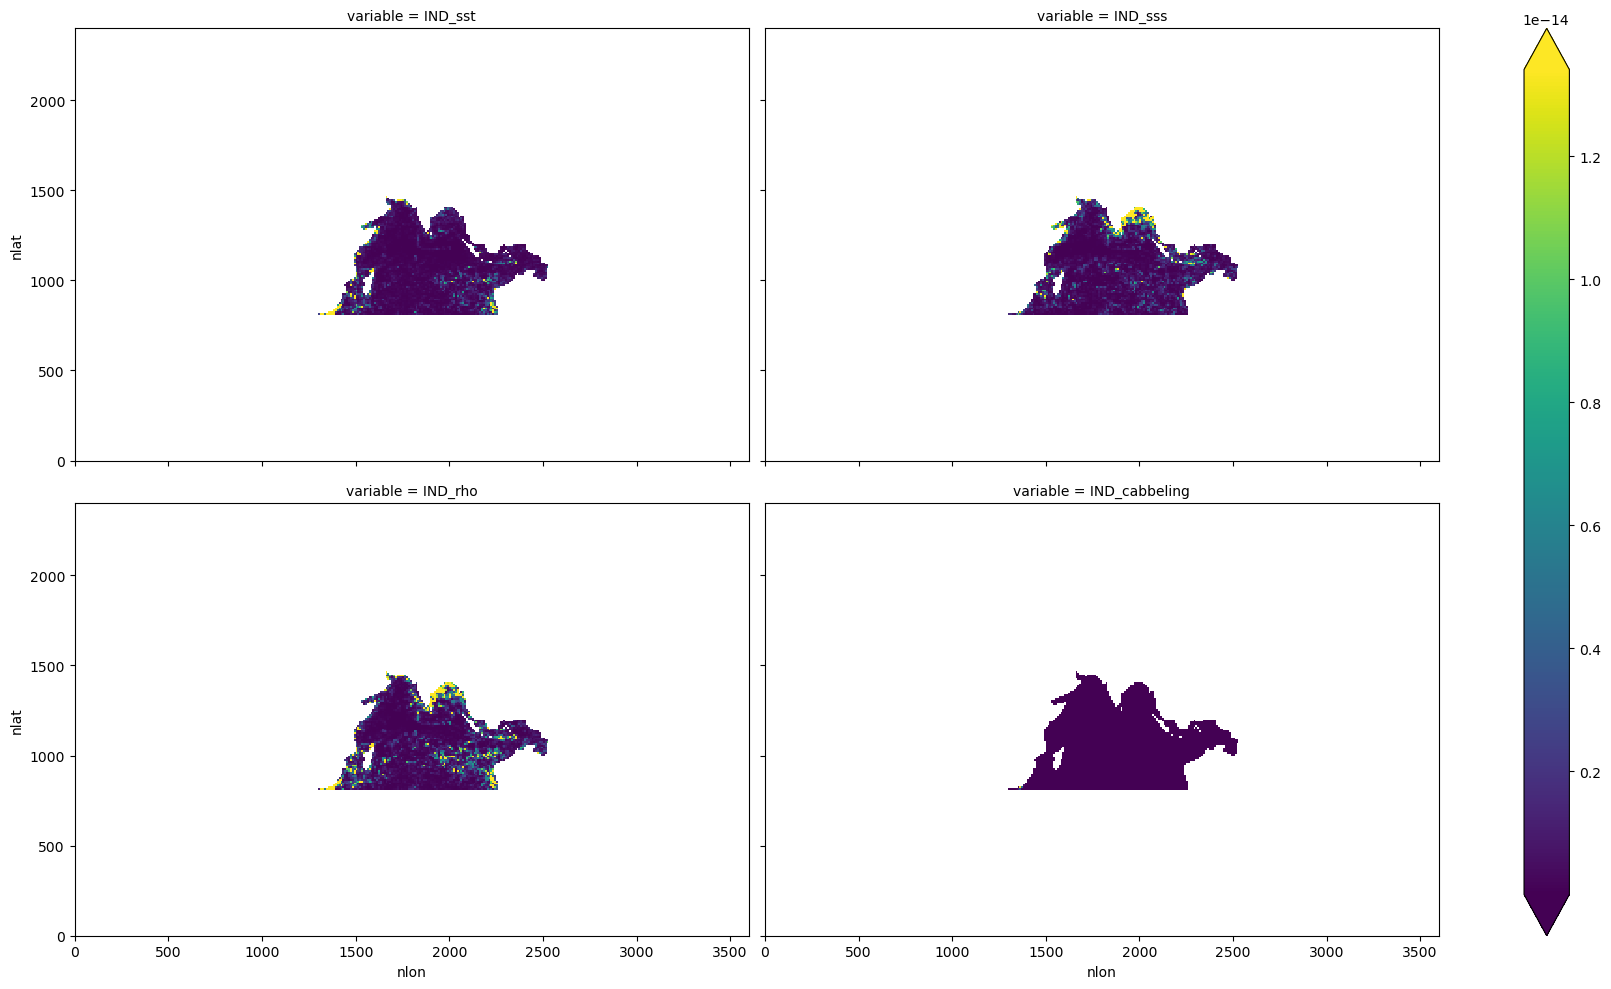

In [23]:
(ind_tend.isel(time=0)**2).coarsen(nlon=10, nlat=10).mean().to_array().plot(col='variable', 
                                                                         col_wrap=2, robust=True, 
                                                                         figsize=(18, 10))

## Arctic

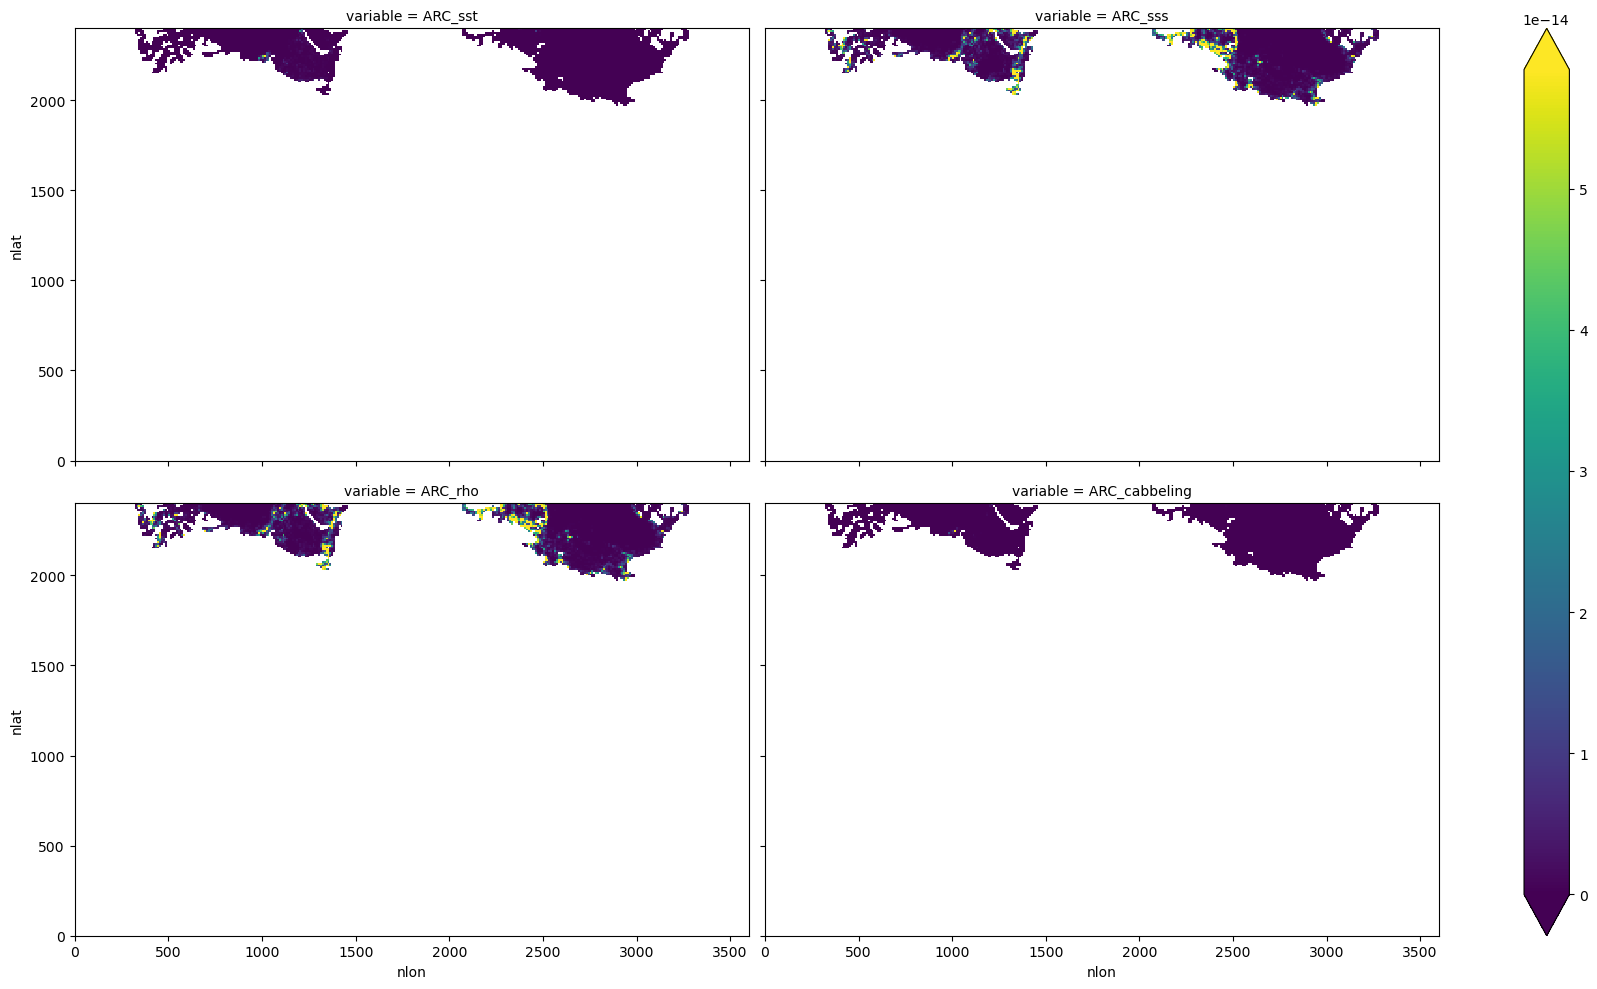

In [24]:
(arc_tend.isel(time=0)**2).coarsen(nlon=10, nlat=10).mean().to_array().plot(col='variable', 
                                                                         col_wrap=2, robust=True, 
                                                                         figsize=(18, 10))

## Southern

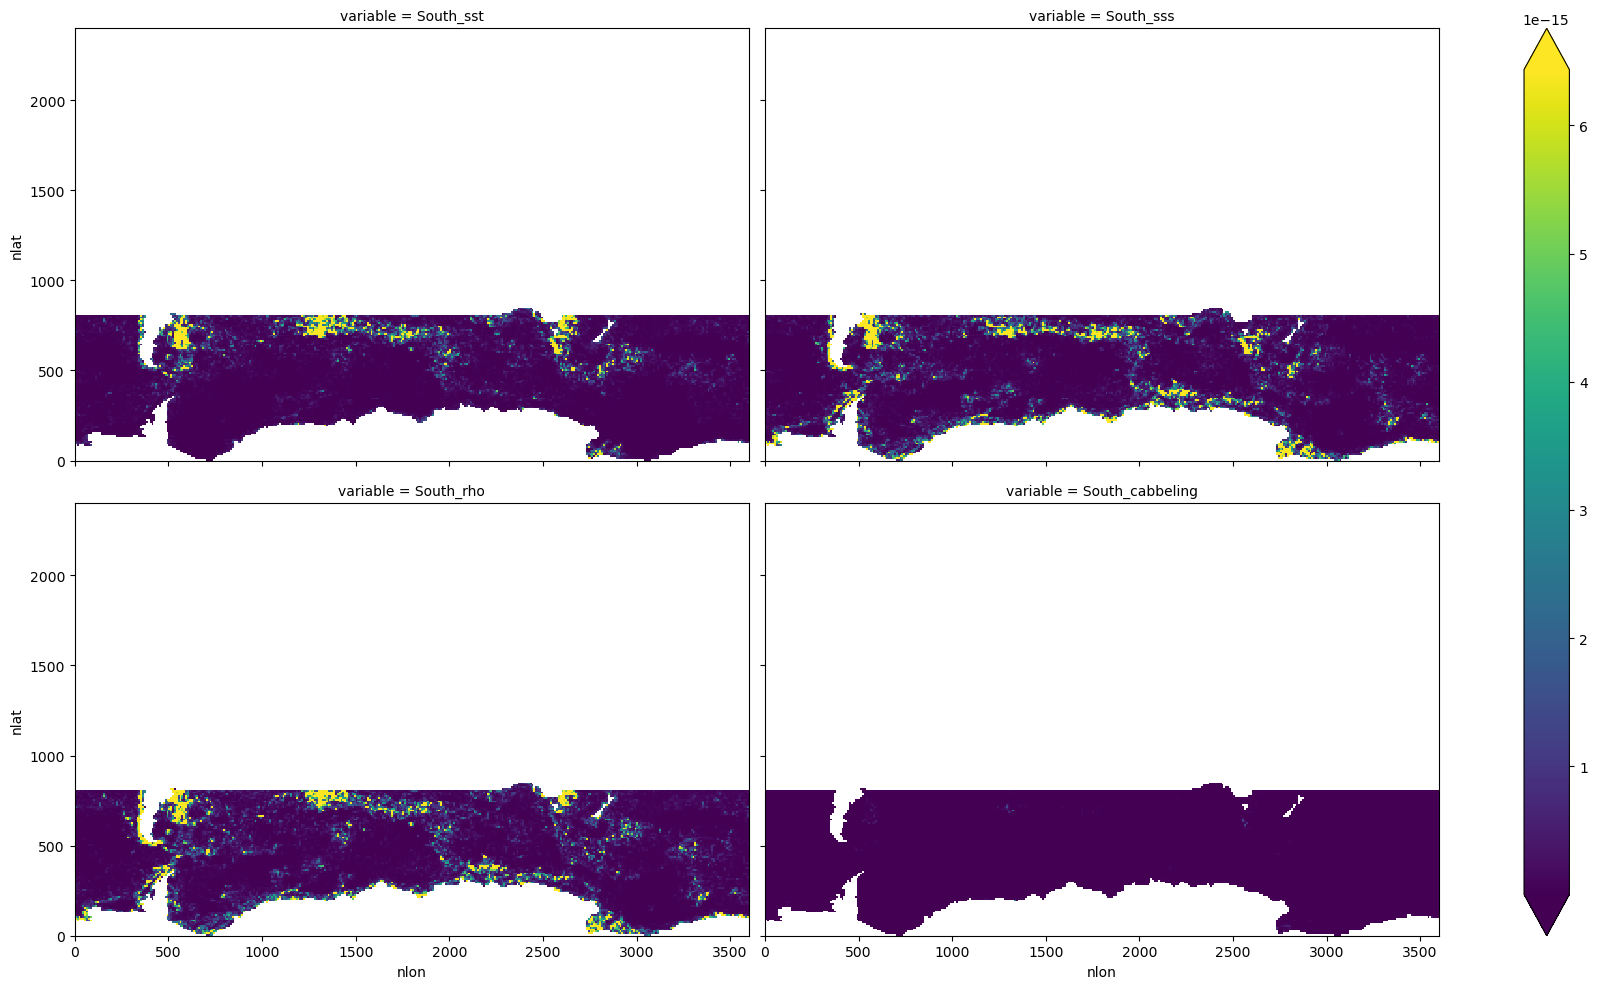

In [25]:
(south_tend.isel(time=0)**2).coarsen(nlon=10, nlat=10).mean().to_array().plot(col='variable', 
                                                                         col_wrap=2, robust=True, 
                                                                         figsize=(18, 10))

## Compute histogram by basin

In [34]:
from dask_gateway import Gateway
gateway = Gateway()
options = gateway.cluster_options()

# set the options programatically, or through their HTML repr
options.worker_memory = 30  # 10 GB of memory per worker.

# Create a cluster with those options
cluster = gateway.new_cluster(options)
cluster.scale(30)
client = cluster.get_client()

In [36]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.ea048df5439d46e0b2f892985f32c2b9/status,


In [33]:
cluster.close()
client.close()

In [17]:
rho = fastjmd95.rho(ds.SSS, ds.SST, 0)
#rho = rho_unsliced.isel(time=slice(0,182))

In [18]:
#area = ds.TAREA * ds.dz * 1e-4 #convert cm^2 to m^2
delta_rho = 0.01
rho_bins = np.arange(1015, 1030, delta_rho)

Text(0.5, 1.0, 'Avg MLD in meters')

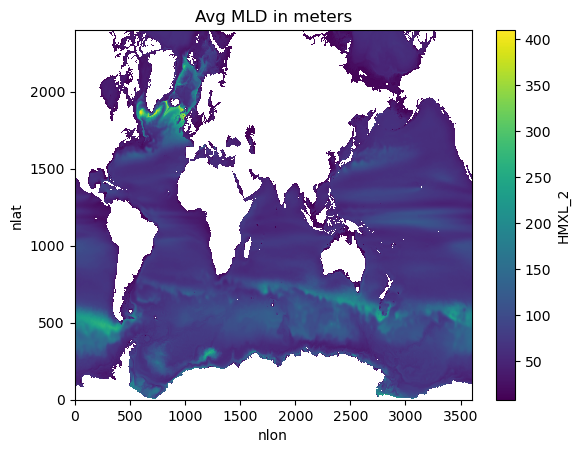

In [21]:
avg_mld = (ds.HMXL_2*1e-2).mean('time').compute()
avg_mld.plot()
plt.title('Avg MLD in meters')

In [22]:
def histogram_func(variable):
    """Generalized xhistogram's histogram function 
    for mixing tendency terms"""
    avg_mld
    cm2_to_m2 = 1e-4
    hist = histogram(rho.rename('rho0'), bins=[rho_bins],
                     weights=(variable.fillna(0.)*(ds.TAREA*cm2_to_m2)*avg_mld), dim=['nlon', 'nlat'])
    return hist / delta_rho

In [23]:
def histogram_func_north_south(variable, slicing=None):
    """Generalized xhistogram's histogram function 
    for mixing tendency terms"""
    avg_mld
    cm2_to_m2 = 1e-4
    if slicing=='north':
        hist = histogram(rho.isel(nlat=slice(1200, None)).rename('rho0'), bins=[rho_bins],
                         weights=(variable.fillna(0.)*(ds.TAREA*cm2_to_m2*avg_mld).isel(nlat=slice(1200, None))), 
                         dim=['nlon', 'nlat']) / delta_rho
    elif slicing=='south':
        hist = histogram(rho.isel(nlat=slice(None, 1200)).rename('rho0'), bins=[rho_bins],
                         weights=(variable.fillna(0.)*(ds.TAREA*cm2_to_m2*avg_mld).isel(nlat=slice(None, 1200))), 
                         dim=['nlon', 'nlat']) / delta_rho
    return hist

In [24]:
natl_histograms = xr.merge([histogram_func_north_south(natl_tend[var], 'north').rename('OMEGA_' + var)
                      for var in natl_tendencies])
satl_histograms = xr.merge([histogram_func_north_south(satl_tend[var], 'south').rename('OMEGA_' + var)
                      for var in satl_tendencies])

In [25]:
npac_histograms = xr.merge([histogram_func_north_south(npac_tend[var], 'north').rename('OMEGA_' + var)
                      for var in npac_tendencies])
spac_histograms = xr.merge([histogram_func_north_south(spac_tend[var], 'south').rename('OMEGA_' + var)
                      for var in spac_tendencies])

In [26]:
ind_histograms = xr.merge([histogram_func(ind_tend[var]).rename('OMEGA_' + var)
                      for var in ind_tendencies])
arc_histograms = xr.merge([histogram_func(arc_tend[var]).rename('OMEGA_' + var)
                      for var in arc_tendencies])
south_histograms = xr.merge([histogram_func(south_tend[var]).rename('OMEGA_' + var)
                      for var in south_tendencies])

# 2) Save histograms <a class='anchor' id='second-bullet'> </a>

In [27]:
client.restart()

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.61f6427177d842889fac636418d0a205/status,


In [28]:
import dask, distributed
dask.config.get('distributed.scheduler.worker-saturation')

1.1

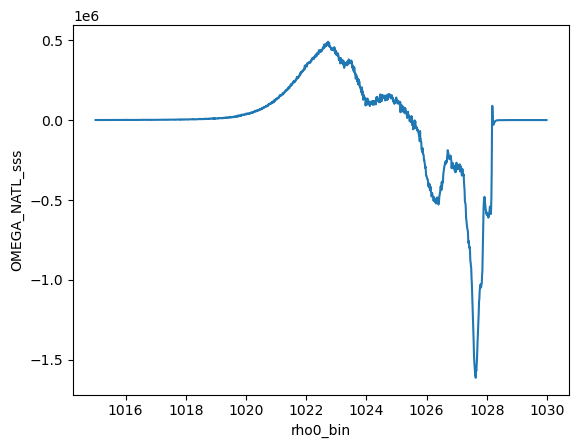

In [46]:
#visual check to see if magnitude is reasonable
natl_histograms.OMEGA_NATL_sss.mean('time').plot()

# FIGS Start

In [37]:
def ann_mean2(ds):
    fig = plt.figure(figsize=(12,5))
    line_colors=['blue', 'k', 
                 'orange', 'green']#, 'purple', 'yellow'] #order of cab, rho, sss, sst, surf heat, surf salt
    for (i,j) in zip(list(ds.data_vars), line_colors):
        (ds[i].mean('time')/1e6).plot(label=f'{i}', color=j)
    plt.legend()
    plt.ylabel(r'Transformation (Sv)', fontsize=16)
    plt.grid()
    plt.title('Annual Mean Transformation Terms', fontsize=20);

In [40]:
client.restart()

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.ea048df5439d46e0b2f892985f32c2b9/status,


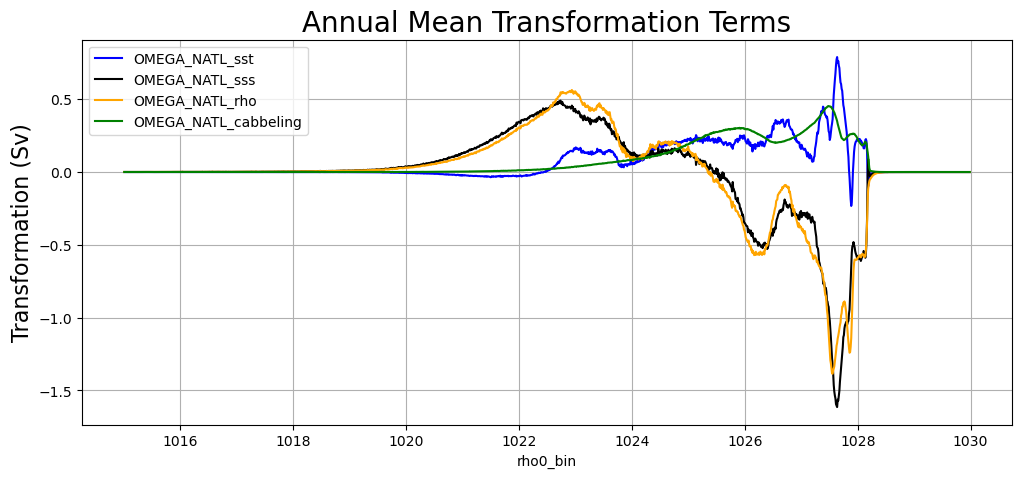

In [41]:
ann_mean2(natl_histograms)

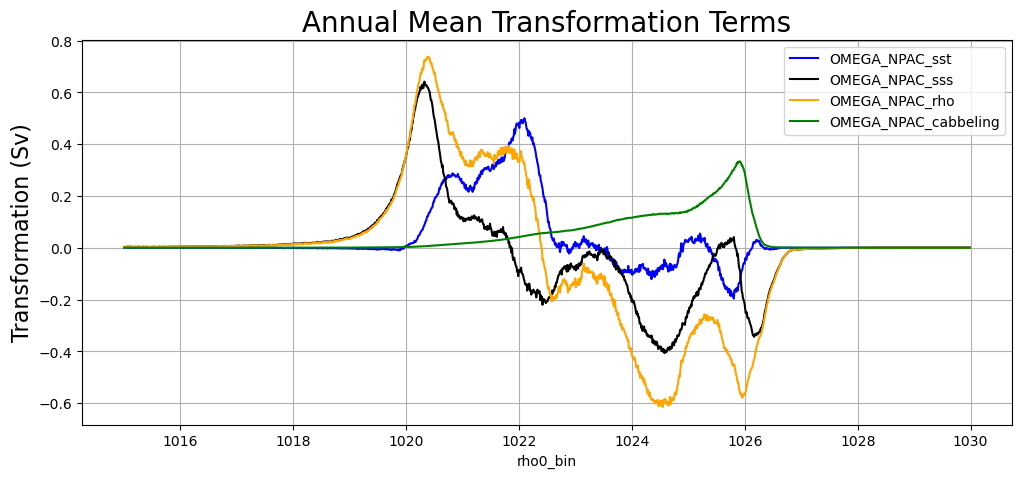

In [42]:
ann_mean2(npac_histograms)

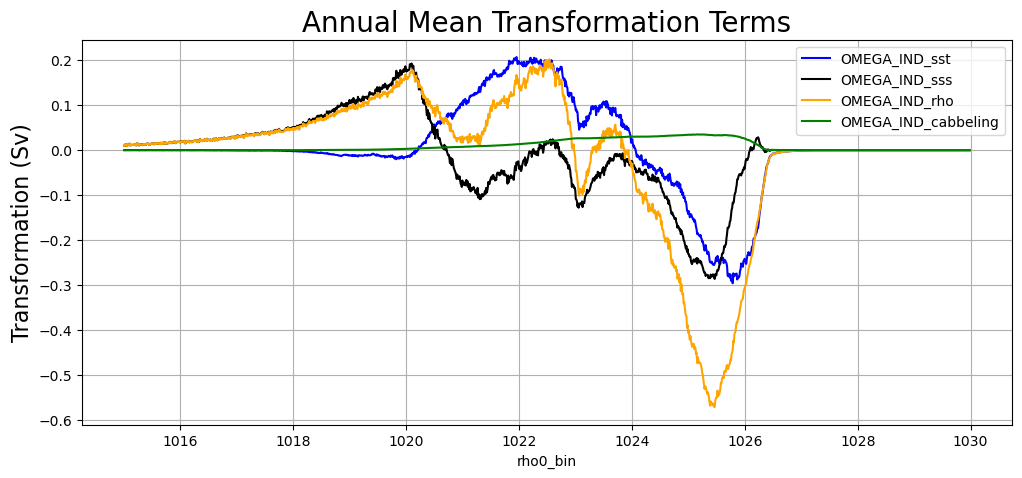

In [43]:
ann_mean2(ind_histograms)

In [ ]:
ann_mean2(arc_histograms)

In [ ]:
ann_mean2(south_histograms)

# FiGS end

In [ ]:
def to_zarr_split(ds, mapper, split_dim="time", split_interval=1):
    print(f"Writing to {mapper.root} ...")

    n = len(ds[split_dim])
    splits = list(range(0, n, split_interval))

    # Make sure the last item in the list covers the full length
    # of the time on our dataset
    if splits[-1] != n:
        splits = splits + [n]

    split_datasets = []
    for ii in range(len(splits) - 1):
        start = splits[ii]
        stop = splits[ii + 1]
        split_datasets.append(ds.isel({split_dim: slice(start, stop)}))

    # write the first array
    # TODO: move the first write to the loop so it is counted in the viz bar
    split_datasets[0].to_zarr(mapper)
    for ds_split in tqdm(split_datasets[1:None]):
        ds_split.to_zarr(mapper, append_dim=split_dim)

    # overwrite the split dimension as single chunk (this should reproduce
    # what xr.to_zarr would do
    g = zarr.open_group(mapper)
    del g[split_dim]
    
    ds[[split_dim]].load().to_zarr(mapper, mode='a')
    zarr.consolidate_metadata(mapper)

In [30]:
#saving north atlantic basin histograms
gcsmap_hist_natl = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/basin-histograms/avg-mld/natl_histograms.zarr')
natl_histograms.to_zarr(gcsmap_hist_natl, mode='w')

KilledWorker: Attempted to run task ('where-getitem-getitem-1ee7a8e7487f6025964d78e3f51e6230', 7879, 0, 0) on 3 different workers, but all those workers died while running it. The last worker that attempt to run the task was tls://10.2.46.3:44827. Inspecting worker logs is often a good next step to diagnose what went wrong. For more information see https://distributed.dask.org/en/stable/killed.html.

In [31]:
client.restart()

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.61f6427177d842889fac636418d0a205/status,


In [ ]:
#saving north pacific basin histograms
gcsmap_hist_npac = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/basin-histograms/avg-mld/npac_histograms.zarr')
npac_histograms.to_zarr(gcsmap_hist_npac, mode='w')

Task exception was never retrieved
future: <Task finished name='Task-15905' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py:2119> exception=AllExit()>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py", line 2128, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-15906' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py:2119> exception=AllExit()>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py", line 2128, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-15907' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/p

In [31]:
cluster.close()
client.close()

[Back to top](#top)